In [1]:

%load_ext autoreload
%autoreload 2

# Test of the scaling framework

In [2]:
%run create_test_data.py

Test data created successfully!
Files created in test:
- base_units.shp (4 rectangles)
- regions.shp (2 regions)
- basin.shp (1 basin)
- test_cover_data.csv (temporal data)


In [3]:
import pandas as pd
import geopandas as gpd
from pathlib import Path

# Set paths
from scaling_framework_functions import (
    SpatialScale,
    plot_spatial_hierarchy,
)

In [4]:
# =============================================================================
# TEST FILE PATHS
# =============================================================================
SPATIAL_PATH = Path("./test/")
DATA_PATH = Path("./test/")
OUTPUT_PATH = Path("./test/output/")

# Test functional group rules
GROUP_RULES = {
    "BaseUnits": {"vegetation": ["Forest", "Grassland"], "water": ["Wetland"]}
}

# =============================================================================
# PROJECTION FOR SPATIAL DATA
# =============================================================================
DEFAULT_CRS = "EPSG:4326"

## Load in the spatial data

The base scale is the smallest atomic unit that is to be aggregated up to larger scales

The aggregation scales are those larger scales - here representing larger regions, and the whole river basin that encompasses all base-scale units.

The SpatialScale object class represents a single spatial scale in the hierarchy.

This class encapsulates spatial ecological data at one organizational level
(e.g., individual wetlands, river reaches, catchments) and provides methods
for scale-appropriate aggregation and analysis.

### SpatialScale()

This constructor loads and validates spatial data into a SpatialScale class object, automatically
detecting geometry types and computing ecologically-appropriate weights.

The SpatialScale initialization:
1. Spatial data validation and CRS standardization
2. Geometry type detection (critical for appropriate weighting)
3. Geometry detection to identify weights:
    - Polygons (habitats): Area in hectares
    - Lines (corridors): Length in meters
    - Points (sites): Count-based weighting
4. Data quality validation and error reporting

#### Arguments:
- name: Identifier for this spatial scale (e.g., 'wetlands', 'catchments')
- source: Path to shapefile containing spatial features
- unique_id_fields: Column(s) that uniquely identify each feature.
    For compound keys use list: ['REGION_ID', 'SITE_ID']
- weighting_field: Column containing ecological weights. If None,
    automatically computed based on geometry type
- metric_fields: Columns containing ecological metrics to aggregate.
    Examples: ['NDVI_mean', 'species_richness', 'water_quality']
- measure_multiplier: Scaling factor for weights (e.g., 0.0001 to
    convert m² to hectares)
- type_field: Column containing functional groups for ecological
    classification (e.g., 'WETLAND_TYPE', 'VEG_COMMUNITY')
- default_crs: Coordinate reference system. Defaults to EPSG:3577
    (Australian Albers) for MDB region
- is_base_scale: True for finest resolution data, False for
    aggregation targets

Loading BaseScale data from base_units.shp...
   Requested: ['SystemType', 'UID', 'Area_Ha', 'geometry']
   Using CRS: GDA94 / Australian Albers.
   All geometries are valid.
   No specific metric fields chosen so loading all columns.
   Loaded: ['UID', 'SystemType', 'Area_Ha', 'NDVI']
   Detected geometry type: polygon (4 features)
No metric fields specified. Inferred: ['NDVI']
Plotting BaseScale...
Result not found. Using BaseScale data. Saved results are []
None not found in the data or not provided. Plotting with default color.Available fields: ['UID', 'SystemType', 'Area_Ha', 'NDVI', 'geometry']


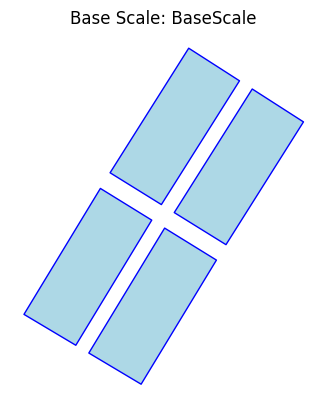

In [5]:
# Setup test environment
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

# Load the base spatial scale
base_scale = SpatialScale(
    name="BaseScale",
    source=SPATIAL_PATH / "base_units.shp",
    unique_id_fields="UID",
    weighting_field="Area_Ha",
    #metric_fields="NDVI",  
    measure_multiplier=None,
    type_field="SystemType",
    is_base_scale=True,
    #default_crs="EPSG:4326"
)

# an inbuilt helper function "plot" draws the geometry of the SpatialScale object that was loaded

base_scale.plot()

## Create  aggregation scale objects

Additional spatial data sets are used to represent the larger scale features (here "regions" and "Basin" that contain the base-scale features loaded in the previous step)

The loading is the same, but here many of the options are not stated, relying on the defaults

In [6]:
#create  aggregation scale objects

region_scale = SpatialScale(
    "Regions",
    source = SPATIAL_PATH / "regions.shp",
    unique_id_fields="RegionID",
)

basin_scale = SpatialScale(
    "Basin",
    source = SPATIAL_PATH / "basin.shp",
    unique_id_fields="BasinID",
)



Loading Regions data from regions.shp...
   Requested: ['RegionID', 'geometry']
   Using CRS: GDA94 / Australian Albers.
   All geometries are valid.
   No specific metric fields chosen so loading all columns.
   Loaded: ['RegionID', 'RegionName']
   Detected geometry type: polygon (2 features)
No metric fields specified. Inferred: []
Loading Basin data from basin.shp...
   Requested: ['BasinID', 'geometry']
   Using CRS: GDA94 / Australian Albers.
   All geometries are valid.
   No specific metric fields chosen so loading all columns.
   Loaded: ['BasinID', 'BasinName']
   Detected geometry type: polygon (1 features)
No metric fields specified. Inferred: []


## Plot the spatial hierarchy for a visual check.


### .plot_spatial_hierarchy()
plot_spatial_hierarchy is a helper function to produce a simple overlay plot of the SpatialScale objects to show their geometry in 2D space.
#### Arguments:
- *args: SpatialScale objects where first is base scale, rest are aggregation scales

Plotting BaseScale with 2 aggregation scales...


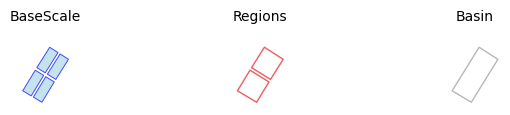

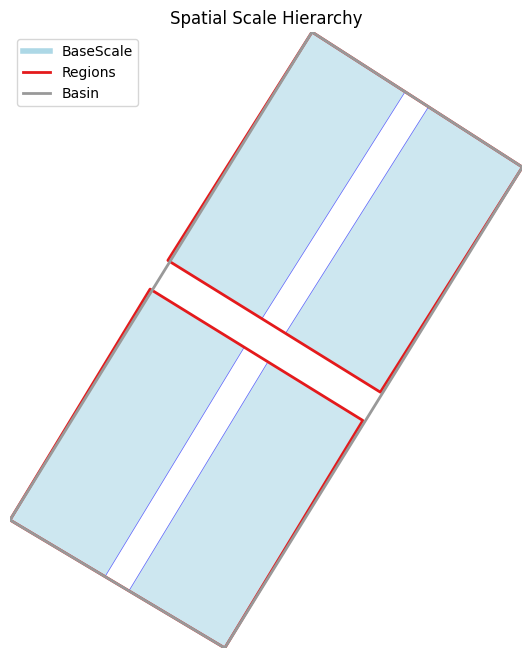

In [7]:

# the first item in the list is the base scale
plot_spatial_hierarchy(base_scale, region_scale, basin_scale)

## Optional: join additional data loaded from a CSV file

Requires a unique id column to match between the SpatialScale object `unique_id_field` so that the data can be joined to the spatial features.
If the data is in wide-form tabular format (wide-form) each row should be a 1:1 match with a unique_id in the base-scale data set. Unmatched rows will be dropped.
If the data is long-form it can be pivoted to wide-form and multiple columns of data will be joined to the base-scale data in a one-to-one relationship


### .join_data()

Load external tabular data and join it to the SpatialScale's data.

Supports:

1. Direct join if data is in wide format (one row per unique_id).
2. Pivoting long data (key-value) into wide before join.

#### Arguments:
- data_path: Path to the CSV or tabular data file.
- unique_id_field: Column in the CSV matching source unique ID. If None, defaults to the unique_id_fields of the parent class opject
- pivot_row_id: If pivoting, list of columns to use as index.
- pivot_columns: If pivoting, column name whose values become new columns.
- pivot_values: If pivoting, column name containing values to fill.
- how: Type of join to perform (default "inner").  Keeps only matching data and discards items with no data.




In [8]:

# Join to base scale
base_scale.join_data(
    data_path=DATA_PATH / "test_cover_data.csv",
    pivot_row_id="UID",
    pivot_columns="year",
    pivot_values="cover",
)


print (base_scale.data.drop(columns=['geometry']).head(10))

No metric fields specified. Inferred: ['2020', '2021', '2022']
Joined external data from test\test_cover_data.csv on '['UID']'
    UID SystemType  Area_Ha  NDVI  2020  2021  2022
0  B001     Forest    200.0  0.80  0.80  0.82  0.78
1  B002    Wetland    200.0  0.60  0.60  0.58  0.62
2  B003     Forest    200.0  0.75  0.75  0.77  0.73
3  B004  Grassland    200.0  0.50  0.50  0.52  0.48


## Optional: reclass_map

A reclass_map is used to reclassify the different entities in the base-scale SpatialScale objects.  This is commonly done in ecology to represent a diverse group of features (or animals and plants) into functional groups.

This may be important where e.g.:

1. **Taxonomic grouping**: Species names may vary but belong to same family
2. **Habitat classification**: Detailed habitat types need broader groupings
3. **Management categories**: Administrative names need functional groupings

The use of substring matching handles common data challenges:
- Inconsistent naming conventions across datasets
- Hierarchical classification systems (species → genus → family)
- Regional variations in habitat terminology

The `reclass_map` is defined using a python dictionary of keywords or phrases to look for in the `type_field`. e.g. any objects with a `type_field` (defined at loading) value that has the words 'marsh', 'swamp' or 'wetland' will be reclassified into a single group called 'Wetlands' for the purpose of the analysis.

```python
# Functional group rules for different base scales
# The rules dictionary maps the base scale name to a dictionary of functional group rules.
# Each set of group rules is a dictionary where the keys are the functional group names
# keyword matching of types to groups is always case insensitive
# the structure is group_name: keywords in the values of the configured type_field

#this example has two different grouping "ANAE" and "Rivers" that can be called on by name

GROUP_RULES = {
    "ANAE": {
        "river red gum woodland": ["river red gum", "woodland"],
        "river red gum swamps and forests": ["river red gum"],
        "black box": ["black box"],
        "coolibah": ["coolibah"],
        "lignum": ["lignum"],
        "cooba": ["cooba"],
        "shrubland": ["f2.4: shrubland riparian zone or floodplain"],
        "submerged lake": ["permanent lake", "permanent wetland", "aquatic bed"],
        "tall reed beds": ["tall emergent marsh"],
        "grassy meadows": ["grass", "meadow"],
        "herbfield": ["forb marsh", "temporary wetland", "temporary lake"],
        "clay pan": ["clay"]
    },
    "Rivers": {
        "Permanent Lowland": ["permanent lowland"],
        "Temporary Lowland": ["temporary lowland"],
        "Other temporary": ["temporary transitional, "],
    }
}
```



In [ ]:
# Functional group rules (a very simple rules dictionary for the test data)
GROUP_RULES = {
    "BaseUnits": {
        "vegetation": ["Forest", "Grassland"],
        "water": ["Wetland"],
    }
}

## Perform Weighted Aggregation to Regions

Spatially join and aggregate base scale metrics into the target scale.

Aggregate ecological metrics from spatially joined data using
ecologically-appropriate weighting schemes.

ECOLOGICAL RATIONALE:
Different ecological metrics require different aggregation approaches:

1. **Area-weighted means**: For intensive properties that represent
    conditions per unit area (e.g., species density, vegetation health,
    water quality). Larger habitats contribute proportionally more.

2. **Length-weighted means**: For linear features like riparian zones
    where longer segments have greater ecological influence.

3. **Count-based aggregation**: For point observations where each
    monitoring site contributes equally regardless of spatial extent.

4. **Frequency-weighted means**: For compositional data where the
    relative abundance of different habitat types matters.

5. **Simple sums**: For extensive properties that accumulate across
    space (e.g., total habitat area, total species count).

        MATHEMATICAL FRAMEWORK:
        All methods use a unified weighted aggregation formula:

        Aggregated_Value = Σ(Metric_i x Weight_i) / Σ(Weight_i)

        Where weights vary by method:
        - Area-weighted: Weight_i = Area_i (hectares)
        - Length-weighted: Weight_i = Length_i (meters)
        - Count-based: Weight_i = 1 (equal weighting)
        - Frequency-weighted: Weight_i = Frequency_i / Total_frequency


### .aggregate_to()
This method implements the core scaling-up logic that transfers
fine-resolution ecological data to broader management scales while
preserving biological meaning and statistical validity.


#### Arguments:
- target_scale: SpatialScale object representing the aggregation
    target (e.g., catchments, management units)
- metric_columns: List of ecological metrics to aggregate.
    Examples: ['NDVI_mean', 'species_richness', 'pH', 'condition_score']
- method: Aggregation method selection:
    - 'area_weighted': Area-proportional weighting (default)
    - 'length_weighted': Length-proportional weighting
    - 'count': Equal weighting for all features
    - 'sum': Additive aggregation without averaging
    - 'frequency_weighted': Compositional weighting by type frequency
- how: Spatial join method (e.g., "intersects", "contains").
- weighting_field: Override default weighting field.
    Useful for custom ecological importance weights
- group_by: Additional grouping variables for stratified analysis.
    Examples: ['management_zone', 'conservation_status']
- reclass_map: Optional functional group classification.
    Dictionary mapping group names to substring lists.
    Example: {'Wetland': ['marsh', 'swamp'], 'Forest': ['woodland', 'trees']}
 -new_class_field: Name for reclassified functional groups column
- keep_unmatched_types: Whether to retain ecological types that
    don't match reclassification patterns
- result_name: Storage key to save aggregated results in the target SpatialScale object as `target_scale.results`


In [10]:
# Geometry-weighted mean NDVI aggregated from base to regions
region_results = base_scale.aggregate_to(
    region_scale,                             #the larger scale we aggregate to
    metric_columns=[2020, 2021, 2022],        #calculate weighted means for each metric - in this case annual data
    method="weighted_mean",                   #base-scale is a polygon feature and an Area-weighted mean is the default
    reclass_map = GROUP_RULES["BaseUnits"],   #reclassify the base_scale types into functional groups
    result_name="2020-2022_weighted_mean3s",  #store the results in the region_scale class
)

Performing spatial join: BaseScale to Regions using 'intersects'
⚠ Warning: Renaming 1 conflicting columns in target scale: {'Area_Ha': 'Area_Ha_target'}
Reclassifying 'SystemType' into new groups 'regrouped' using substring match from reclass map...

Classification mapping applied: 'SystemType' → 'regrouped'
  'Forest'      → 'vegetation'
  'Grassland'   → 'vegetation'
  'Wetland'     → 'water'

Total unique types: 3
Functional groups created: 2

Aggregating by ['RegionID', 'regrouped'] using 'weighted_mean' method
Processing 4 spatially joined records
Target metrics: ['2020', '2021', '2022']

✓ Aggregation complete. Results stored in Regions.results['2020-2022_weighted_mean3s']
  - 3 aggregated records created
  - Columns: ['RegionID', 'regrouped', '2020_arewm', '2021_arewm', '2022_arewm']


In [11]:
# Geometry-weighted mean NDVI aggregated from base to regions
region_results = base_scale.aggregate_to(
    region_scale,
    metric_columns=[2020, 2021, 2022],
    method="weighted_mean",
    weighting_field="NDVI",    #this time using a field value to define the weighting 
    reclass_map = GROUP_RULES["BaseUnits"],
    #result_name="cover_NDVI_weighted_annual_mean",
)

Using 'NDVI' for 'NDVI_weighted' aggregation
Using cached spatial join: Regions_intersects
Reclassifying 'SystemType' into new groups 'regrouped' using substring match from reclass map...

Classification mapping applied: 'SystemType' → 'regrouped'
  'Forest'      → 'vegetation'
  'Grassland'   → 'vegetation'
  'Wetland'     → 'water'

Total unique types: 3
Functional groups created: 2

Aggregating by ['RegionID', 'regrouped'] using 'weighted_mean' method
Processing 4 spatially joined records
Target metrics: ['2020', '2021', '2022']


# List all saved results

In [12]:
region_scale.save_results("list")


Available results:
  2020-2022_weighted_mean3s      -          3 rows ['RegionID', 'regrouped', '2020_arewm', '2021_arewm', '2022_arewm']


# Perform Attribute-Weighted Aggregation to Regions

In [13]:
basin_result= base_scale.aggregate_to(
    basin_scale,
    metric_columns=[2020, 2021, 2022],
    method="weighted_mean",
    reclass_map = GROUP_RULES["BaseUnits"],
    result_name="Area_weighted_mean",
)

Performing spatial join: BaseScale to Basin using 'intersects'
⚠ Warning: Renaming 1 conflicting columns in target scale: {'Area_Ha': 'Area_Ha_target'}
Reclassifying 'SystemType' into new groups 'regrouped' using substring match from reclass map...

Classification mapping applied: 'SystemType' → 'regrouped'
  'Forest'      → 'vegetation'
  'Grassland'   → 'vegetation'
  'Wetland'     → 'water'

Total unique types: 3
Functional groups created: 2

Aggregating by ['BasinID', 'regrouped'] using 'weighted_mean' method
Processing 4 spatially joined records
Target metrics: ['2020', '2021', '2022']

✓ Aggregation complete. Results stored in Basin.results['Area_weighted_mean']
  - 2 aggregated records created
  - Columns: ['BasinID', 'regrouped', '2020_arewm', '2021_arewm', '2022_arewm']


# Frequency-Weighted Aggregation to Basin

In [14]:
# Geometry-weighted mean NDVI aggregated from base to regions
basin_result= base_scale.aggregate_to(
    basin_scale,
    metric_columns=[2020, 2021, 2022],
    method="frequency_weighted",
    reclass_map = GROUP_RULES["BaseUnits"],
    result_name="NDVI_frequency_weighted_mean",
)


Using cached spatial join: Basin_intersects
Reclassifying 'SystemType' into new groups 'regrouped' using substring match from reclass map...

Classification mapping applied: 'SystemType' → 'regrouped'
  'Forest'      → 'vegetation'
  'Grassland'   → 'vegetation'
  'Wetland'     → 'water'

Total unique types: 3
Functional groups created: 2

Aggregating by ['BasinID', 'regrouped'] using 'frequency_weighted' method
Processing 4 spatially joined records
Target metrics: ['2020', '2021', '2022']

✓ Aggregation complete. Results stored in Basin.results['NDVI_frequency_weighted_mean']
  - 2 aggregated records created
  - Columns: ['BasinID', 'regrouped', '2020_frqwm', '2021_frqwm', '2022_frqwm']


In [15]:
#list the various results that were saved into the target SpatialScale object

basin_scale.save_results("list")

Available results:
  Area_weighted_mean             -          2 rows ['BasinID', 'regrouped', '2020_arewm', '2021_arewm', '2022_arewm']
  NDVI_frequency_weighted_mean   -          2 rows ['BasinID', 'regrouped', '2020_frqwm', '2021_frqwm', '2022_frqwm']


In [16]:
#save the results to file as CSV, Shapefiles or GeoPackages


region_scale.save_results(OUTPUT_PATH, file_types=["csv", "shp", "gpkg"])

basin_scale.save_results(OUTPUT_PATH, file_types=["csv", "shp"])

Saved .CSV: d:\Flow MER\mdb-scaling-up\output\Regions_2020-2022_weighted_mean3s.csv
Saved .SHP: d:\Flow MER\mdb-scaling-up\output\Regions_2020-2022_weighted_mean3s.shp
Saved .GPKG: d:\Flow MER\mdb-scaling-up\output\Regions_2020-2022_weighted_mean3s.gpkg
Saved .CSV: d:\Flow MER\mdb-scaling-up\output\Basin_Area_weighted_mean.csv
Saved .SHP: d:\Flow MER\mdb-scaling-up\output\Basin_Area_weighted_mean.shp
Saved .CSV: d:\Flow MER\mdb-scaling-up\output\Basin_NDVI_frequency_weighted_mean.csv
Saved .SHP: d:\Flow MER\mdb-scaling-up\output\Basin_NDVI_frequency_weighted_mean.shp


## Visualisation

Plotting BaseScale...
Result not found. Using BaseScale data. Saved results are []
Reclassifying 'SystemType' into new groups 'regrouped' using substring match from reclass map...

Classification mapping applied: 'SystemType' → 'regrouped'
  'Forest'      → 'vegetation'
  'Grassland'   → 'vegetation'
  'Wetland'     → 'water'

Total unique types: 3
Functional groups created: 2


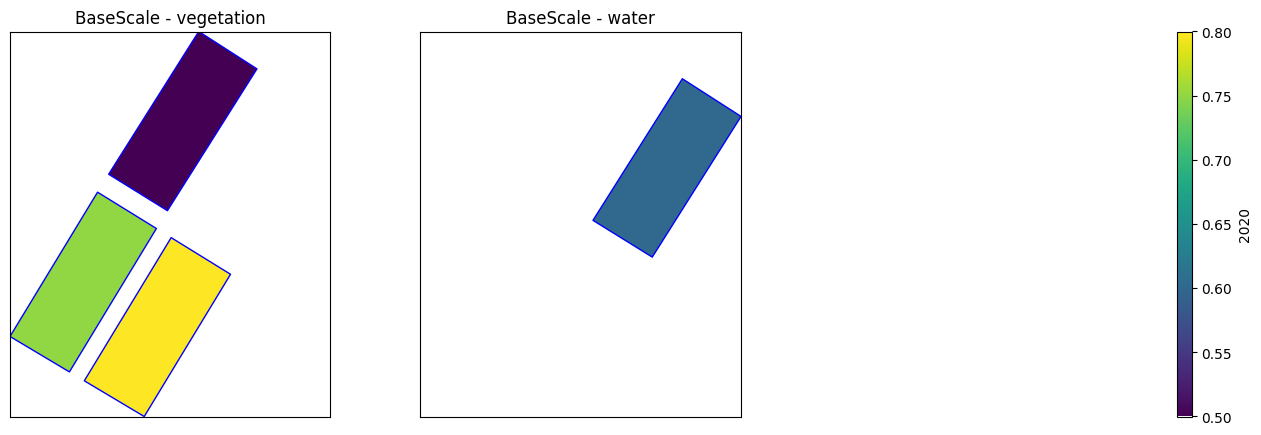

Plotting Regions...


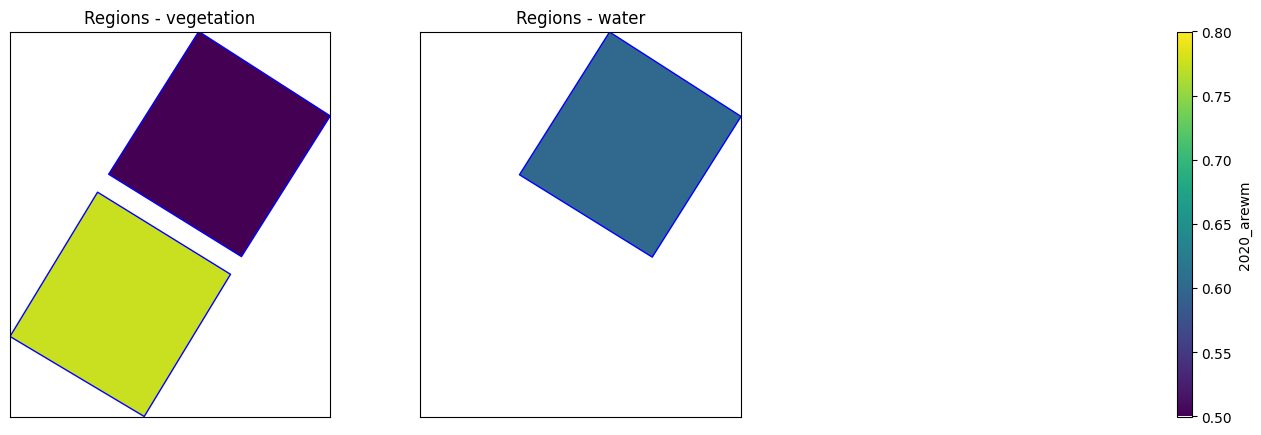

Plotting Basin...


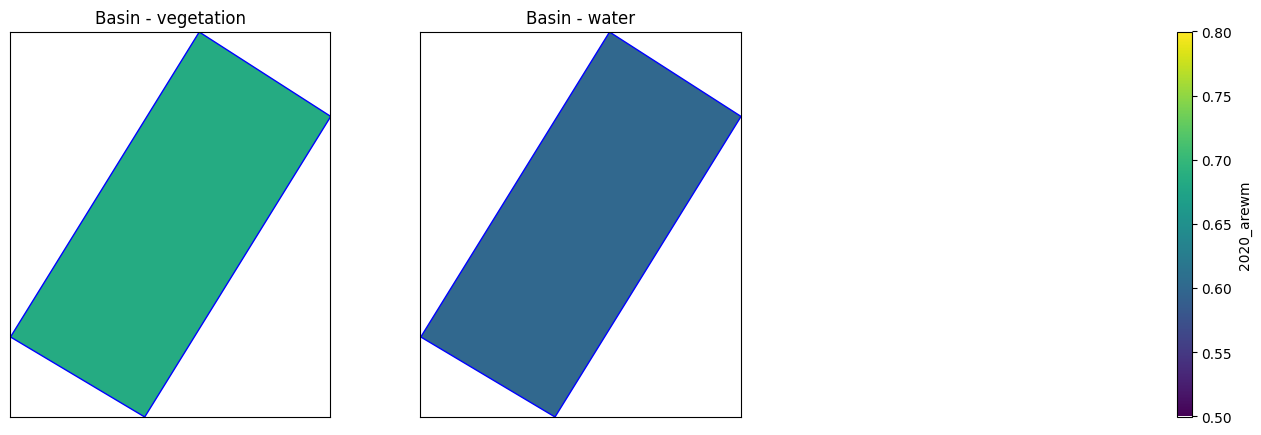

In [17]:
#Plot the results to visualise

vmin= 0.5
vmax=0.8


base_scale.plot(field="2020", reclass_map = GROUP_RULES["BaseUnits"], vmin=vmin, vmax=vmax)
region_scale.plot(result ="2020-2022_weighted_mean3s", field="2020_arewm", vmin=vmin, vmax=vmax)
basin_scale.plot(result="Area_weighted_mean", field="2020_arewm", vmin=vmin, vmax=vmax)
